In [1]:
import os
import sys
import numpy as np
import sklearn as skl
import time
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

import torch.nn as nn

sys.path.append("../../../")
import CalibratedTimeseriesModels
from CalibratedTimeseriesModels.utils import *


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# load data
X_orig = torch.load("../../../datasets/processed/openEI/X_openei_011_subset_multitask.pt")
Y_orig = torch.load("../../../datasets/processed/openEI/Y_openei_011_subset_multitask.pt")

past_dims = 24
fut_dims = 12

X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = electric_train_test_split(X_orig, Y_orig, disp_idx=past_dims+fut_dims)

In [3]:
train_idxs = [*range(past_dims)] #,*range(-6,0,1)]

X_train = X_train_orig[1,:,train_idxs].reshape((-1,len(train_idxs))).unsqueeze(-1).float()
Y_train = Y_train_orig[1,:,:fut_dims].reshape((-1,fut_dims)).unsqueeze(-1).float()
X_test = X_test_orig[1,:,train_idxs].reshape((-1,len(train_idxs))).unsqueeze(-1).float()
Y_test = Y_test_orig[1,:,:fut_dims].reshape((-1,fut_dims)).unsqueeze(-1).float()

In [4]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, covar_kernel=gpytorch.kernels.RBFKernel(), index_rank=2):
        B, num_tasks = train_y.shape
        self.num_tasks = num_tasks
        self.index_rank = index_rank
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=self.num_tasks
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            covar_kernel, num_tasks=self.num_tasks, rank=self.index_rank
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [76]:
torch.cuda.empty_cache()
train_x, train_y = X_train.reshape(X_train.size(0),-1).cuda(), Y_train.reshape(Y_train.size(0),-1).cuda()

covar_kernel = gpytorch.kernels.RBFKernel(ard_num_dims=24)
index_rank = 12 
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=12).cuda()
model = MultitaskGPModel(train_x, train_y, likelihood, covar_kernel=covar_kernel, index_rank=index_rank).cuda()

In [77]:
training_iter = 75

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.05)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    if i%10==0:
        print('Iter %d/%d - Mean Loss: %.3f' % (i + 1, training_iter, loss.item()/train_x.size(0)))
    optimizer.step()

Iter 1/75 - Mean Loss: 1.459
Iter 11/75 - Mean Loss: 1.140
Iter 21/75 - Mean Loss: 0.842
Iter 31/75 - Mean Loss: 0.570
Iter 41/75 - Mean Loss: 0.307
Iter 51/75 - Mean Loss: 0.053
Iter 61/75 - Mean Loss: -0.172
Iter 71/75 - Mean Loss: -0.306


In [78]:
model.eval()
likelihood.eval()
test_x = X_test.reshape(X_test.size(0),-1)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = test_x.cuda()
    dist = model(test_x)
    predictions = likelihood(dist)
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

In [80]:
for f in [mape, wape, rmse, rwse]:
    print(f(dist,Y_test.cuda()))

(tensor(0.0796, device='cuda:0'), tensor([0.0353, 0.0468, 0.0584, 0.0732, 0.0846, 0.0842, 0.0855, 0.0924, 0.0932,
        0.0966, 0.1012, 0.1040], device='cuda:0'), tensor([0.0420, 0.0561, 0.0718, 0.0898, 0.1056, 0.1029, 0.1064, 0.1161, 0.1168,
        0.1177, 0.1211, 0.1217], device='cuda:0'))
(tensor(0.2162, device='cuda:0'), tensor([0.1587, 0.1644, 0.1770, 0.2007, 0.2160, 0.2009, 0.2037, 0.2333, 0.2613,
        0.2381, 0.2650, 0.2747], device='cuda:0'), tensor([0.0762, 0.0831, 0.0938, 0.1096, 0.1243, 0.1165, 0.1162, 0.1352, 0.1407,
        0.1392, 0.1546, 0.1561], device='cuda:0'))
(tensor(0.1715, device='cuda:0'), tensor([0.0037, 0.0065, 0.0108, 0.0190, 0.0282, 0.0297, 0.0326, 0.0416, 0.0429,
        0.0442, 0.0475, 0.0462], device='cuda:0'), tensor([0.0112, 0.0196, 0.0348, 0.0674, 0.1023, 0.1115, 0.1212, 0.1527, 0.1516,
        0.1512, 0.1556, 0.1397], device='cuda:0'))
(tensor(0.3216, device='cuda:0'), tensor([0.0432, 0.0482, 0.0594, 0.0819, 0.1021, 0.0922, 0.0920, 0.1261, 0.1435

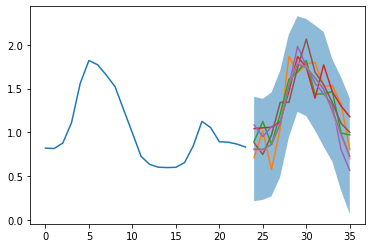

In [81]:
plt.plot(range(24),X_test[0,:,0])
plt.plot(range(24,36), samples[:5,0,:].T)
plt.plot(range(24,36),Y_test[0,:]) #orange
plt.plot(range(24,36),mean[0,:].cpu())
plt.fill_between(range(24,36), lower[0,:].cpu(), upper[0,:].cpu(), alpha=0.5)
plt.show()

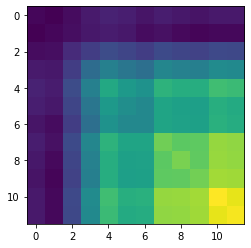

In [91]:
with torch.no_grad():
    K = model.covar_module.task_covar_module._eval_covar_matrix()
    plt.imshow(K.cpu().numpy())

In [8]:
train_x = torch.linspace(0, 1, 15)
train_y = torch.sin(train_x * (2 * math.pi))

class SpectralMixtureGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(SpectralMixtureGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=4)
        self.covar_module.initialize_from_data(train_x, train_y)

    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = SpectralMixtureGPModel(train_x, train_y, likelihood)

/home/arec/miniconda3/envs/ctm/lib/python3.7/site-packages/gpytorch/kernels/spectral_mixture_kernel.py:206: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629403081/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  min_dist[:, ind] = min_dist_sort[((min_dist_sort[:, ind]).nonzero())[0], ind]
